In [1]:
import sys
import numpy as np
import cv2
from time import sleep
from datetime import datetime
import os
import numpy as np
from matplotlib import pyplot as plt
from pandas import read_csv, read_excel, DataFrame
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
p1 = os.path.join('C:\\Users\\joaquin','usda','raw','CookIRCamET','Images','NsarIRCal')
p2 = os.path.join('C:\\Users\\joaquin','usda','work','CookIRCamET','Working')
p3 = os.path.join('C:\\Users\\joaquin','usda','raw','CookIRCamET','Images','CprlIRCal')
p4 = os.path.join('C:\\Users\\joaquin','usda','work','CookIRCamET','Working')
p5 = os.path.join('C:\\Users\\joaquin','usda','raw','CookIRCamET','Images','NsarIRCalFlir')
p6 = os.path.join('C:\\Users\\joaquin','usda','work','CookIRCamET','Working')



In [2]:
bgr_5_9 = cv2.imread(os.path.join(p1,'cal_5_9_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_5_9 = cv2.imread(os.path.join(p1,'cal_5_9_ir.png'),cv2.IMREAD_UNCHANGED)
bgr_7_0 = cv2.imread(os.path.join(p1,'cal_7_0_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_7_0 = cv2.imread(os.path.join(p1,'cal_7_0_ir.png'),cv2.IMREAD_UNCHANGED)
bgr_7_2 = cv2.imread(os.path.join(p1,'cal_7_2_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_7_2 = cv2.imread(os.path.join(p1,'cal_7_2_ir.png'),cv2.IMREAD_UNCHANGED)
bgr_7_5 = cv2.imread(os.path.join(p1,'cal_7_5_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_7_5 = cv2.imread(os.path.join(p1,'cal_7_5_ir.png'),cv2.IMREAD_UNCHANGED)

bgr_35_4 = cv2.imread(os.path.join(p1,'cal_35_4_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_35_4 = cv2.imread(os.path.join(p1,'cal_35_4_ir.png'),cv2.IMREAD_UNCHANGED)
bgr_36_2 = cv2.imread(os.path.join(p1,'cal_36_2_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_36_2 = cv2.imread(os.path.join(p1,'cal_36_2_ir.png'),cv2.IMREAD_UNCHANGED)
bgr_37_1 = cv2.imread(os.path.join(p1,'cal_37_1_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_37_1 = cv2.imread(os.path.join(p1,'cal_37_1_ir.png'),cv2.IMREAD_UNCHANGED)
bgr_38_0 = cv2.imread(os.path.join(p1,'cal_38_0_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_38_0 = cv2.imread(os.path.join(p1,'cal_38_0_ir.png'),cv2.IMREAD_UNCHANGED)
bgr_39_4 = cv2.imread(os.path.join(p1,'cal_39_4_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_39_4 = cv2.imread(os.path.join(p1,'cal_39_4_ir.png'),cv2.IMREAD_UNCHANGED)


In [3]:
bgr_20_0 = cv2.imread(os.path.join(p3,'20220430170628_nofix_20C_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_20_0 = cv2.imread(os.path.join(p3,'20220430170628_nofix_20C_ir.png'),cv2.IMREAD_UNCHANGED)
bgr_25_0 = cv2.imread(os.path.join(p3,'20220430170937_nofix_25C_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_25_0 = cv2.imread(os.path.join(p3,'20220430170937_nofix_25C_ir.png'),cv2.IMREAD_UNCHANGED)
bgr_30_0 = cv2.imread(os.path.join(p3,'20220430171240_nofix_30C_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_30_0 = cv2.imread(os.path.join(p3,'20220430171240_nofix_30C_ir.png'),cv2.IMREAD_UNCHANGED)
bgr_35_0 = cv2.imread(os.path.join(p3,'20220430171612_nofix_35C_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_35_0 = cv2.imread(os.path.join(p3,'20220430171612_nofix_35C_ir.png'),cv2.IMREAD_UNCHANGED)


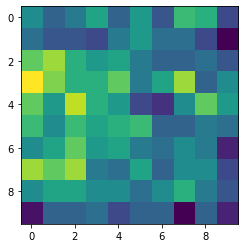

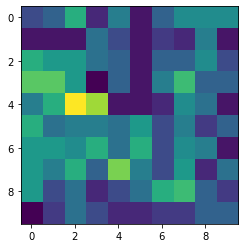

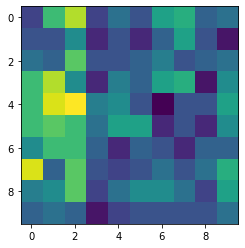

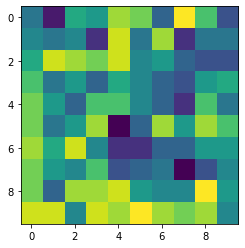

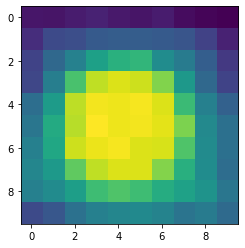

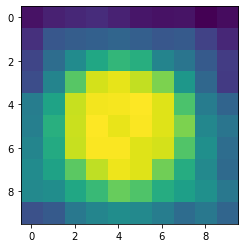

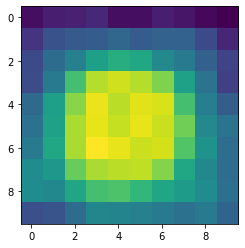

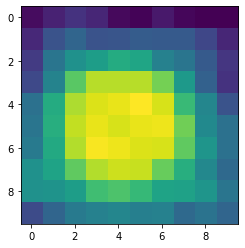

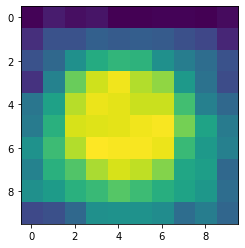

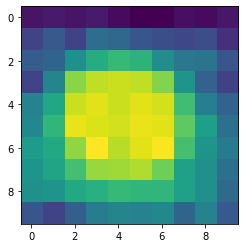

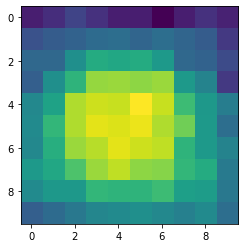

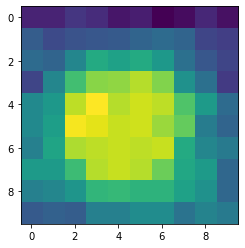

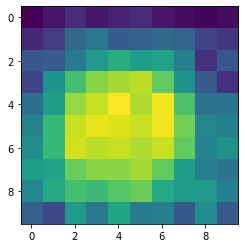

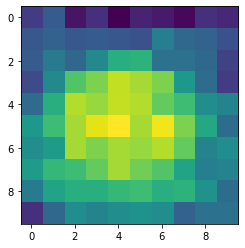

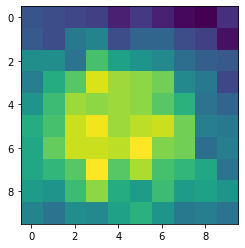

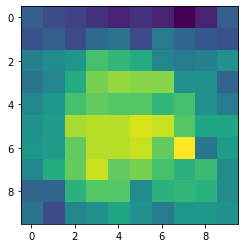

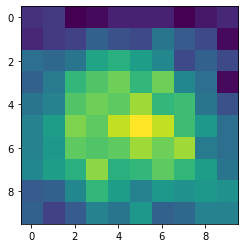

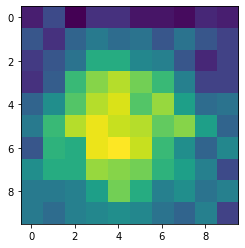

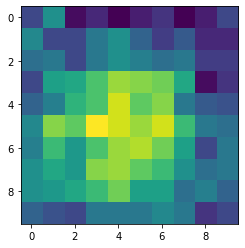

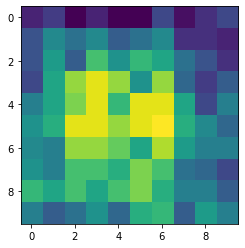

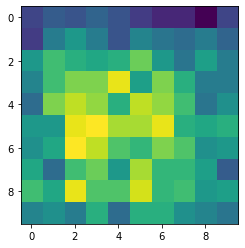

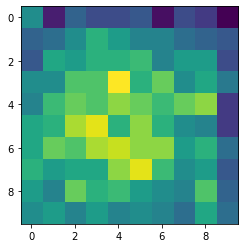

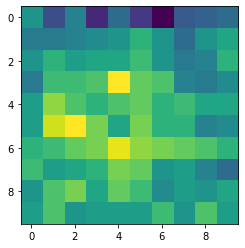

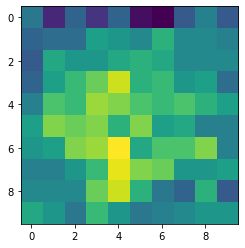

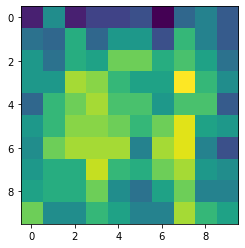

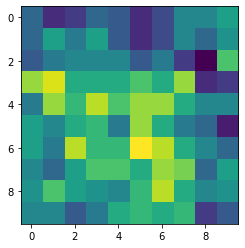

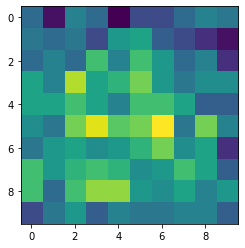

In [73]:
bgr_42_6 = cv2.imread(os.path.join(p5,'20220630191615_42_6_bgr.png'),cv2.IMREAD_UNCHANGED)
ir_42_6 = cv2.imread(os.path.join(p5,'20220630191615_42_6_ir.png'),cv2.IMREAD_UNCHANGED)
flir_max = np.max(np.max(ir_42_6))
i,j=np.where(ir_42_6==flir_max)
j=j+2#adjust
t_ir_flir=[]
t_meas_flir=[]
for f in os.listdir(p5):
    if '_ir' in f:
        ir = cv2.imread(os.path.join(p5,f),cv2.IMREAD_UNCHANGED)
        t_ir_flir.append(np.mean(ir[int(i)-3:int(i)+3,int(j)-3:int(j)+3]))
        t_meas_flir.append(int(f.split('_')[1])+int(f.split('_')[2])/10) 
        plt.imshow(ir[int(i)-5:int(i)+5,int(j)-5:int(j)+5])
        plt.show()

In [74]:
t_meas_flir=np.array(t_meas_flir).reshape(-1,1)+273.15
t_ir_flir=np.array(t_ir_flir).reshape(-1,1)

In [75]:
vmax,vmin = np.max(np.max(ir_39_4)),np.min(np.min(ir_5_9))

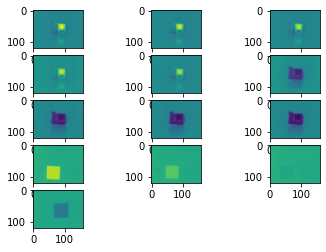

In [76]:
plt.subplot(5,3,1)
plt.imshow(ir_39_4, vmin=vmin, vmax=vmax)
plt.subplot(5,3,2)
plt.imshow(ir_38_0, vmin=vmin, vmax=vmax)
plt.subplot(5,3,3)
plt.imshow(ir_37_1, vmin=vmin, vmax=vmax)
plt.subplot(5,3,4)
plt.imshow(ir_36_2, vmin=vmin, vmax=vmax)
plt.subplot(5,3,5)
plt.imshow(ir_35_4, vmin=vmin, vmax=vmax)
plt.subplot(5,3,6)
plt.imshow(ir_7_5, vmin=vmin, vmax=vmax)
plt.subplot(5,3,7)
plt.imshow(ir_7_2, vmin=vmin, vmax=vmax)
plt.subplot(5,3,8)
plt.imshow(ir_7_0, vmin=vmin, vmax=vmax)
plt.subplot(5,3,9)
plt.imshow(ir_5_9, vmin=vmin, vmax=vmax)
plt.subplot(5,3,10)
plt.imshow(ir_35_0, vmin=vmin, vmax=vmax)
plt.subplot(5,3,11)
plt.imshow(ir_30_0, vmin=vmin, vmax=vmax)
plt.subplot(5,3,12)
plt.imshow(ir_25_0, vmin=vmin, vmax=vmax)
plt.subplot(5,3,13)
plt.imshow(ir_20_0, vmin=vmin, vmax=vmax)

In [77]:
i,j=np.where(ir_5_9==np.min(np.min(ir_5_9)))
t_5_9=np.mean(ir_5_9[int(i)-5:int(i)+5,int(j)-5:int(j)+5])

i,j=np.where(ir_7_0==np.min(np.min(ir_7_0)))
t_7_0=np.mean(ir_7_0[int(i)-5:int(i)+5,int(j)-5:int(j)+5])

i,j=np.where(ir_7_2==np.min(np.min(ir_7_2)))
t_7_2=np.mean(ir_7_2[int(i)-5:int(i)+5,int(j)-5:int(j)+5])

i,j=np.where(ir_7_5==np.min(np.min(ir_7_5)))
t_7_5=np.mean(ir_7_5[int(i)-5:int(i)+5,int(j)-5:int(j)+5])


In [78]:
i,j=np.where(ir_39_4==np.max(np.max(ir_39_4)))
t_39_4=np.mean(ir_39_4[int(i)-5:int(i)+5,int(j)-5:int(j)+5])

i,j=np.where(ir_38_0==np.max(np.max(ir_38_0)))
t_38_0=np.mean(ir_38_0[int(i)-5:int(i)+5,int(j)-5:int(j)+5])

i,j=np.where(ir_37_1==np.max(np.max(ir_37_1)))
t_37_1=np.mean(ir_37_1[int(i)-5:int(i)+5,int(j)-5:int(j)+5])

i,j=np.where(ir_36_2==np.max(np.max(ir_36_2)))
t_36_2=np.mean(ir_36_2[int(i)-5:int(i)+5,int(j)-5:int(j)+5])

i,j=np.where(ir_35_4==np.max(np.max(ir_35_4)))
t_35_4=np.mean(ir_35_4[int(i)-5:int(i)+5,int(j)-5:int(j)+5])

In [79]:
i,j=np.where(ir_35_0==np.max(np.max(ir_35_0)))
t_35_0=np.mean(ir_35_0[int(i)-5:int(i)+5,int(j)-5:int(j)+5])
ir_35_0[int(i)-5:int(i)+5,int(j)-5:int(j)+5]

array([[30759, 30757, 30779, 30759, 30763, 30767, 30771, 30769, 30773,
        30777],
       [30748, 30761, 30767, 30761, 30761, 30773, 30773, 30761, 30775,
        30785],
       [30752, 30767, 30771, 30763, 30763, 30777, 30775, 30763, 30777,
        30775],
       [30753, 30759, 30767, 30763, 30761, 30775, 30771, 30769, 30773,
        30769],
       [30750, 30757, 30750, 30761, 30761, 30771, 30769, 30771, 30779,
        30759],
       [30755, 30767, 30759, 30765, 30775, 30791, 30765, 30769, 30773,
        30773],
       [30767, 30753, 30771, 30769, 30767, 30769, 30771, 30773, 30765,
        30773],
       [30759, 30769, 30773, 30767, 30763, 30773, 30775, 30773, 30773,
        30775],
       [30755, 30773, 30781, 30773, 30765, 30777, 30777, 30773, 30767,
        30775],
       [30761, 30759, 30769, 30769, 30759, 30775, 30765, 30769, 30769,
        30767]], dtype=uint16)

In [80]:
t_30_0=np.mean(ir_30_0[int(i)-5:int(i)+5,int(j)-5:int(j)+5])
ir_30_0[int(i)-5:int(i)+5,int(j)-5:int(j)+5]
i,j

(array([97], dtype=int64), array([50], dtype=int64))

In [81]:
#i,j=np.where(ir_25_0==np.max(np.max(ir_25_0)))
t_25_0=np.mean(ir_25_0[int(i)-5:int(i)+5,int(j)-5:int(j)+5])
ir_25_0[int(i)-5:int(i)+5,int(j)-5:int(j)+5]

array([[29852, 29869, 29854, 29858, 29869, 29884, 29850, 29839, 29861,
        29835],
       [29871, 29875, 29880, 29869, 29873, 29878, 29867, 29848, 29867,
        29839],
       [29869, 29846, 29863, 29890, 29858, 29880, 29856, 29850, 29863,
        29858],
       [29850, 29882, 29865, 29875, 29867, 29865, 29852, 29858, 29852,
        29873],
       [29867, 29873, 29871, 29867, 29878, 29878, 29884, 29856, 29854,
        29844],
       [29852, 29875, 29871, 29865, 29884, 29882, 29869, 29880, 29869,
        29861],
       [29858, 29867, 29850, 29861, 29856, 29873, 29869, 29865, 29875,
        29848],
       [29839, 29865, 29865, 29873, 29865, 29861, 29861, 29861, 29863,
        29852],
       [29865, 29867, 29882, 29886, 29863, 29880, 29861, 29873, 29861,
        29848],
       [29850, 29865, 29884, 29867, 29882, 29873, 29888, 29890, 29869,
        29846]], dtype=uint16)

In [82]:
i,j=np.where(ir_20_0==np.min(np.min(ir_20_0)))
i = int(np.mean(i))
j = int(np.mean(j))
t_20_0=np.mean(ir_20_0[int(i)-5:int(i)+5,int(j)-5:int(j)+5])

In [83]:
T_nsar = np.array([5.9,7.0,7.2,7.5,35.4,36.2,37.1,38.0,39.4])+273.15
IR_nsar = np.array([t_5_9,t_7_0,t_7_2,t_7_5,t_35_4,t_36_2,t_37_1,t_38_0,t_39_4])

In [84]:
T_cprl = np.array([20,25,30,35])+273.15
IR_cprl = np.array([t_20_0,t_25_0,t_30_0,t_35_0])

In [85]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(IR_nsar.reshape(-1,1),T_nsar.reshape(-1,1))
T_pred_nsar = model.intercept_+model.coef_*IR_nsar

In [86]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(t_ir_flir,t_meas_flir)
T_pred_flir = model.intercept_+model.coef_*t_ir_flir

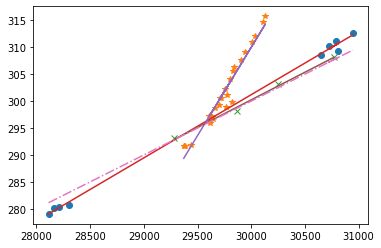

In [87]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(IR_cprl.reshape(-1,1),T_cprl.reshape(-1,1))
T_pred_cprl = model.intercept_+model.coef_*IR_cprl
plt.plot(IR_nsar,T_nsar,'o',t_ir_flir,t_meas_flir,'*',IR_cprl,T_cprl,'x',IR_nsar,T_pred_nsar.reshape(-1,1),'-',t_ir_flir,T_pred_flir.reshape(-1,1),'-',IR_cprl,T_pred_cprl.reshape(-1,1),'-',IR_nsar,IR_nsar/100,'-.')

In [38]:
model.intercept_,model.coef_

(array([-7.31657001]), array([[0.01025149]]))